In [1]:
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

In [2]:
# Path to decoder results
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")

In [3]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "SQuAD", "QQP", "MNLI", "SST", "LM", "LM_lmonly", "LM_scrambled", "LM_lmonly_scrambled"]
checkpoint_steps = list(range(5,255,5))
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4]

In [4]:
# Load decoder performance data.
decoding_perfs = util.load_decoding_perfs(decoder_path, glob_prefix="encodings.")

In [5]:
## Calculate decoder MAR performance post-hoc.

# Load decoder prediction data.
decoding_preds = util.load_decoding_preds(decoder_path, glob_prefix="encodings.")
rank_perfs = {}
for decoding_preds_key, pred_data in tqdm(list(decoding_preds.items())):
    model, run, step, subject = decoding_preds_key
    
    # Load decoder target data.
    model_path = bert_encoding_path / ("encodings.%s.%s.%s-run%i-%i.npy" % (finetune_desc, bert_base_model, model, run, step))
    model_encodings = np.load(model_path)
    model_encodings /= np.linalg.norm(model_encodings, axis=1, keepdims=True)
    
    if pred_data.shape[1] != model_encodings.shape[1]:
        # model encodings were down-projected -- let's recapitulate that
        from sklearn.decomposition import PCA
        pca = PCA(pred_data.shape[1])
        model_encodings = pca.fit_transform(model_encodings)

    _, rank_of_correct = util.eval_ranks(pred_data, np.arange(len(pred_data)), model_encodings)
    rank_perfs[model, run, step, subject] = pd.Series(rank_of_correct).agg(["mean", "median", "max", "min"])
    
decoding_rank_data = pd.concat(rank_perfs, names=["model", "run", "step", "subject"]).unstack().rename(columns=lambda c: "rank_%s" % c)
decoding_rank_data.to_csv("decoding_rank_data.csv")

100%|██████████| 10311/10311 [1:04:39<00:00,  3.65it/s]


In [16]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    
    m_target_runs = [-1] if model is None else target_runs
    for target_run in m_target_runs:
        target_run_str = "" if target_run == -1 else "-run%i" % target_run
        
        if model is None:
            model_dir = bert_path / bert_base_model
        else:
            # DEV
            model_dir = bert_path / ("%s.%s.%s%s" % (finetune_desc, bert_base_model, model, target_run_str))

        try:
            metadata = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        except: pass
        
        if metadata["steps"]:
            model_metadata[model, target_run] = pd.DataFrame.from_dict(metadata["steps"], orient="index")

model_metadata = pd.concat(model_metadata, names=["model", "run", "step"])

None
Missing training events file in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
SQuAD
QQP
MNLI
SST
LM
LM_lmonly
LM_scrambled
LM_lmonly_scrambled


In [17]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    for target_run in target_runs:
        target_run_str = "" if target_run is None else "-run%i" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata.loc["SQuAD", target_run, checkpoint_step]["eval_accuracy"] = \
                    results["best_f1"] / 100.
            except: pass

In [18]:
# Join decoding data, post-hoc rank evaluation data, and model training metadata into a single df.
old_index = decoding_perfs.index
df = decoding_perfs.join(decoding_rank_data) \
                   .reset_index().join(model_metadata, on=["model", "run", "step"]).set_index(old_index.names)
df.head()

mse        r2  rank_mean  rank_median  rank_max  \
model run step subject                                                         
LM    1   5    M02      0.003481 -0.053856  38.020833         15.0     335.0   
               M04      0.003648 -0.056622  60.078125         34.0     371.0   
               M07      0.003583 -0.056325  48.289062         23.5     376.0   
               M08      0.003654 -0.060064  62.015625         31.5     368.0   
               M09      0.003670 -0.054741  58.705729         30.5     379.0   

                        rank_min  total_global_norms  train_loss  \
model run step subject                                             
LM    1   5    M02           0.0           17.460516    2.906655   
               M04           0.0           17.460516    2.906655   
               M07           0.0           17.460516    2.906655   
               M08           0.0           17.460516    2.906655   
               M09           0.0           17.460516    2.906655   

                        train_loss_norm  eval_accuracy  eval_loss  
model run step subject                                             
LM    1   5    M02                  NaN       0.590395        NaN  
               M04                  NaN       0.590395        NaN  
               M07                  NaN       0.590395        NaN  
               M08                  NaN       0.590395        NaN  
               M09                  NaN       0.590395        NaN

-----------

In [19]:
all_subjects = df.index.get_level_values("subject").unique()
all_subjects

Index(['M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15', 'P01'], dtype='object', name='subject')

### Synthetic columns

In [20]:
df["eval_accuracy_delta"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda xs: xs - xs.iloc[0])
df["decoding_mse_delta"] = df.groupby(["model", "run", "subject"]).mse.transform(lambda xs: xs - xs.iloc[0])
df["rank_mean_delta"] = df.groupby(["model", "run", "subject"]).rank_mean.transform(lambda xs: xs - xs.iloc[0])
df["rank_median_delta"] = df.groupby(["model", "run", "subject"]).rank_median.transform(lambda xs: xs - xs.iloc[0])
df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

In [21]:
NUM_BINS = 50
df["eval_accuracy_bin"] = df.groupby(["model"]).eval_accuracy.transform(lambda xs: pd.cut(xs, np.linspace(xs.min(), xs.max(), NUM_BINS), labels=False))
df["decoding_mse_bin"] = df.groupby(["subject"]).decoding_mse_delta.transform(lambda xs: pd.cut(xs, np.linspace(xs.min(), xs.max(), NUM_BINS), labels=False))

In [22]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["mse", "decoding_mse_delta", "eval_accuracy", "train_loss", "rank_mean", "rank_mean_delta"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE).mean())

In [23]:
df.tail()

mse        r2   rank_mean  rank_median  rank_max  \
model run step subject                                                          
SST   4   250  M08      0.003686 -0.063790  147.135417        132.0     377.0   
               M09      0.003752 -0.059510  150.713542        134.0     383.0   
               M14      0.003833 -0.015657  161.221354        150.0     383.0   
               M15      0.003694 -0.057596  143.838542        124.5     382.0   
               P01      0.003530 -0.048363  125.309896         98.0     382.0   

                        rank_min  total_global_norms  train_loss  \
model run step subject                                             
SST   4   250  M08           0.0          280.965663    0.136338   
               M09           0.0          280.965663    0.136338   
               M14           0.0          280.965663    0.136338   
               M15           0.0          280.965663    0.136338   
               P01           0.0          280.965663    0.136338   

                        train_loss_norm  eval_accuracy  \
model run step subject                                   
SST   4   250  M08             0.068169        0.90711   
               M09             0.068169        0.90711   
               M14             0.068169        0.90711   
               M15             0.068169        0.90711   
               P01             0.068169        0.90711   

                                 ...             rank_median_delta  \
model run step subject           ...                                 
SST   4   250  M08               ...                          68.0   
               M09               ...                          63.5   
               M14               ...                          60.5   
               M15               ...                          63.5   
               P01               ...                          44.5   

                        eval_accuracy_norm  eval_accuracy_bin  \
model run step subject                                          
SST   4   250  M08                0.998943               48.0   
               M09                0.998943               48.0   
               M14                0.998943               48.0   
               M15                0.998943               48.0   
               P01                0.998943               48.0   

                        decoding_mse_bin  mse_rolling  \
model run step subject                                  
SST   4   250  M08                  23.0     0.003697   
               M09                  23.0     0.003727   
               M14                  34.0     0.003834   
               M15                  27.0     0.003678   
               P01                  29.0     0.003529   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
SST   4   250  M08                        0.000061               0.906422   
               M09                        0.000029               0.906422   
               M14                        0.000094               0.906422   
               M15                        0.000101               0.906422   
               P01                        0.000073               0.906422   

                        train_loss_rolling  rank_mean_rolling  \
model run step subject                                          
SST   4   250  M08                0.183471         145.356250   
               M09                0.183471         151.517708   
               M14                0.183471         163.668750   
               M15                0.183471         141.790625   
               P01                0.183471         124.078125   

                        rank_mean_delta_rolling  
model run step subject                           
SST   4   250  M08                    47.205208  
               M09                    55.970833  
               M14                

In [24]:
dfi = df.reset_index()

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


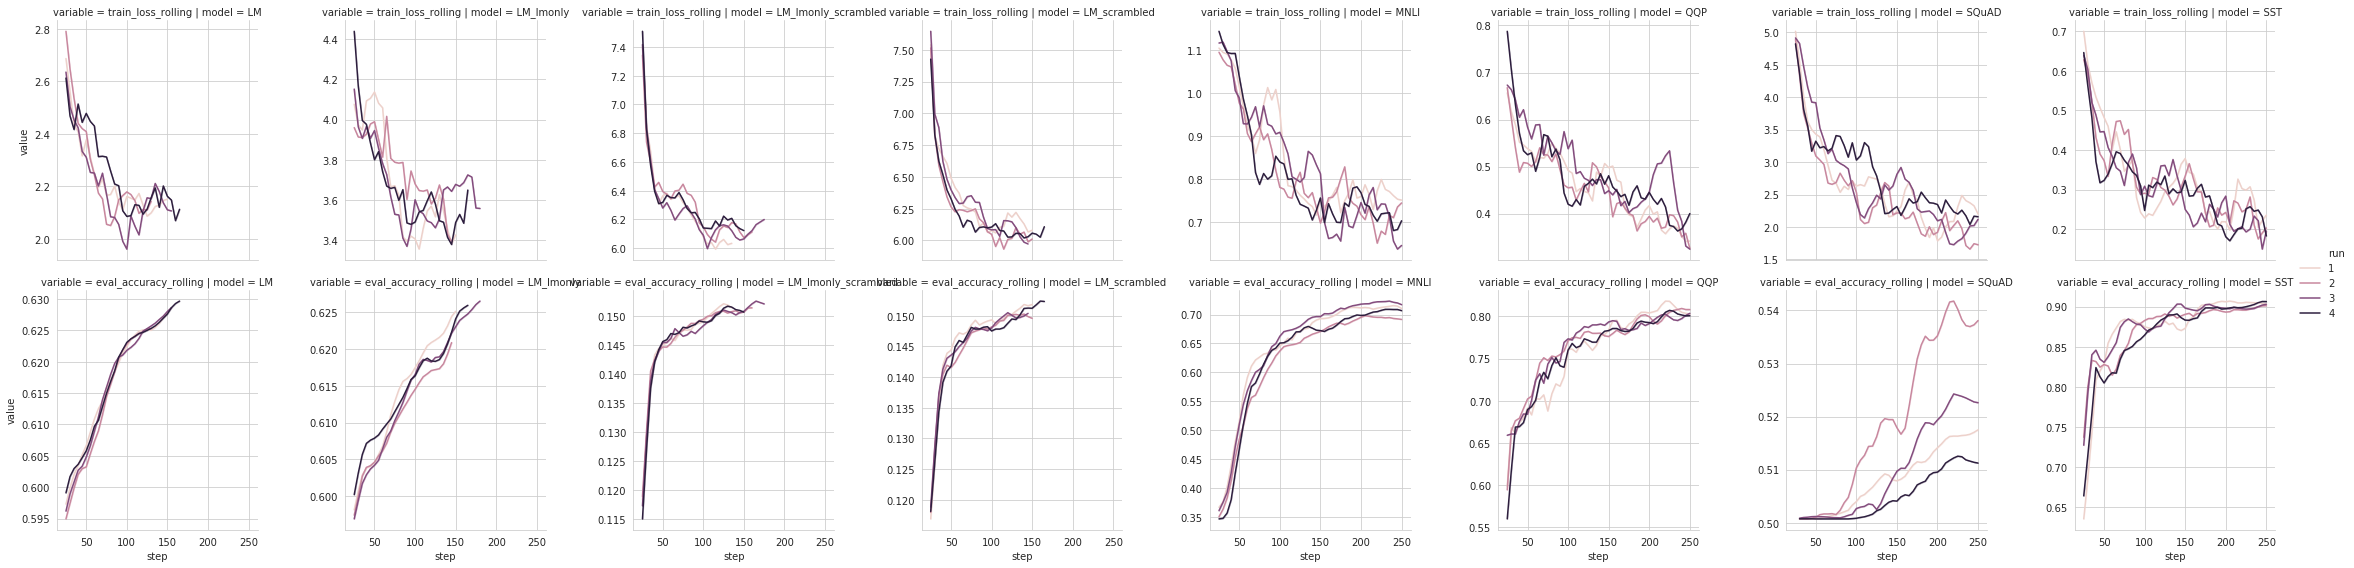

In [25]:
g = sns.FacetGrid(df.reset_index().melt(id_vars=["model", "run", "step"],
                                        value_vars=["train_loss_rolling", "eval_accuracy_rolling"]),
                  row="variable", col="model", sharex=True, sharey=False, height=4)
g.map(sns.lineplot, "step", "value", "run")
g.add_legend()

## Decoding analyses

In [26]:
MSE_DELTA_LABEL = "$\Delta$(MSE)"
MAR_DELTA_LABEL = "$\Delta(MAR)$"

### Step analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(1426.57,0.5,'$\\Delta$(MSE)')

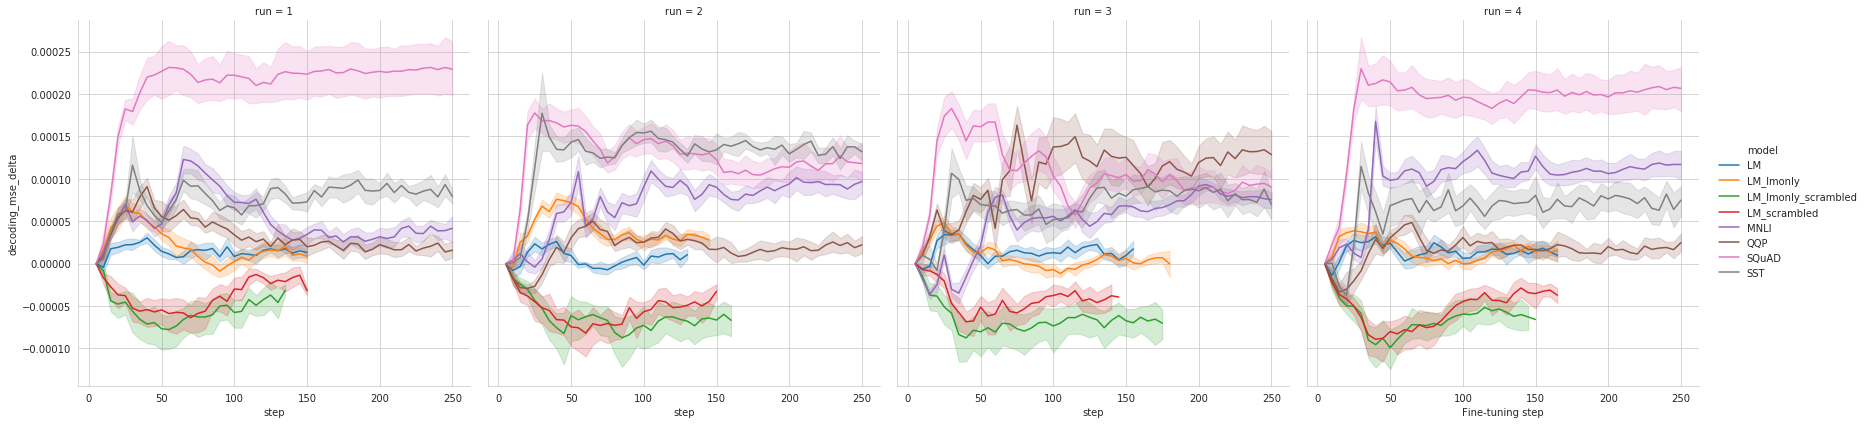

In [27]:
g = sns.FacetGrid(dfi, col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mse_delta", "model").add_legend()

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(1420.6,0.5,'$\\Delta(MAR)$')

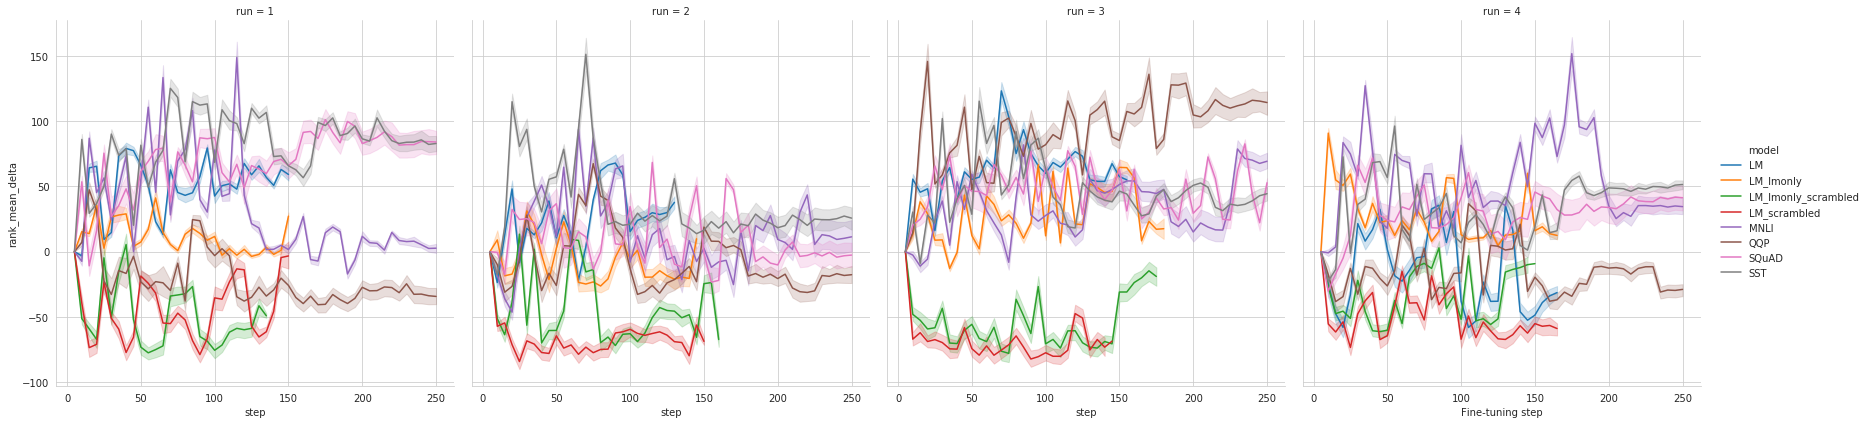

In [28]:
g = sns.FacetGrid(dfi, col="run", size=6)
g.map(sns.lineplot, "step", "rank_mean_delta", "model").add_legend()

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

Text(0,0.5,'$\\Delta$(MSE)')

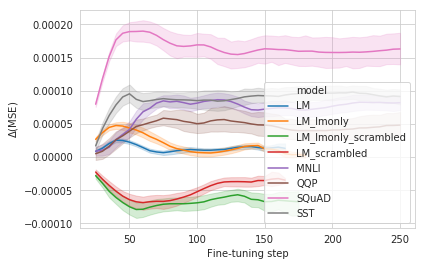

In [29]:
sns.lineplot(data=dfi, x="step", y="decoding_mse_delta_rolling", hue="model")

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

Text(0,0.5,'$\\Delta(MAR)$')

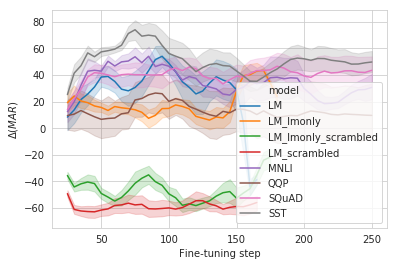

In [30]:
sns.lineplot(data=dfi, x="step", y="rank_mean_delta_rolling", hue="model")

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


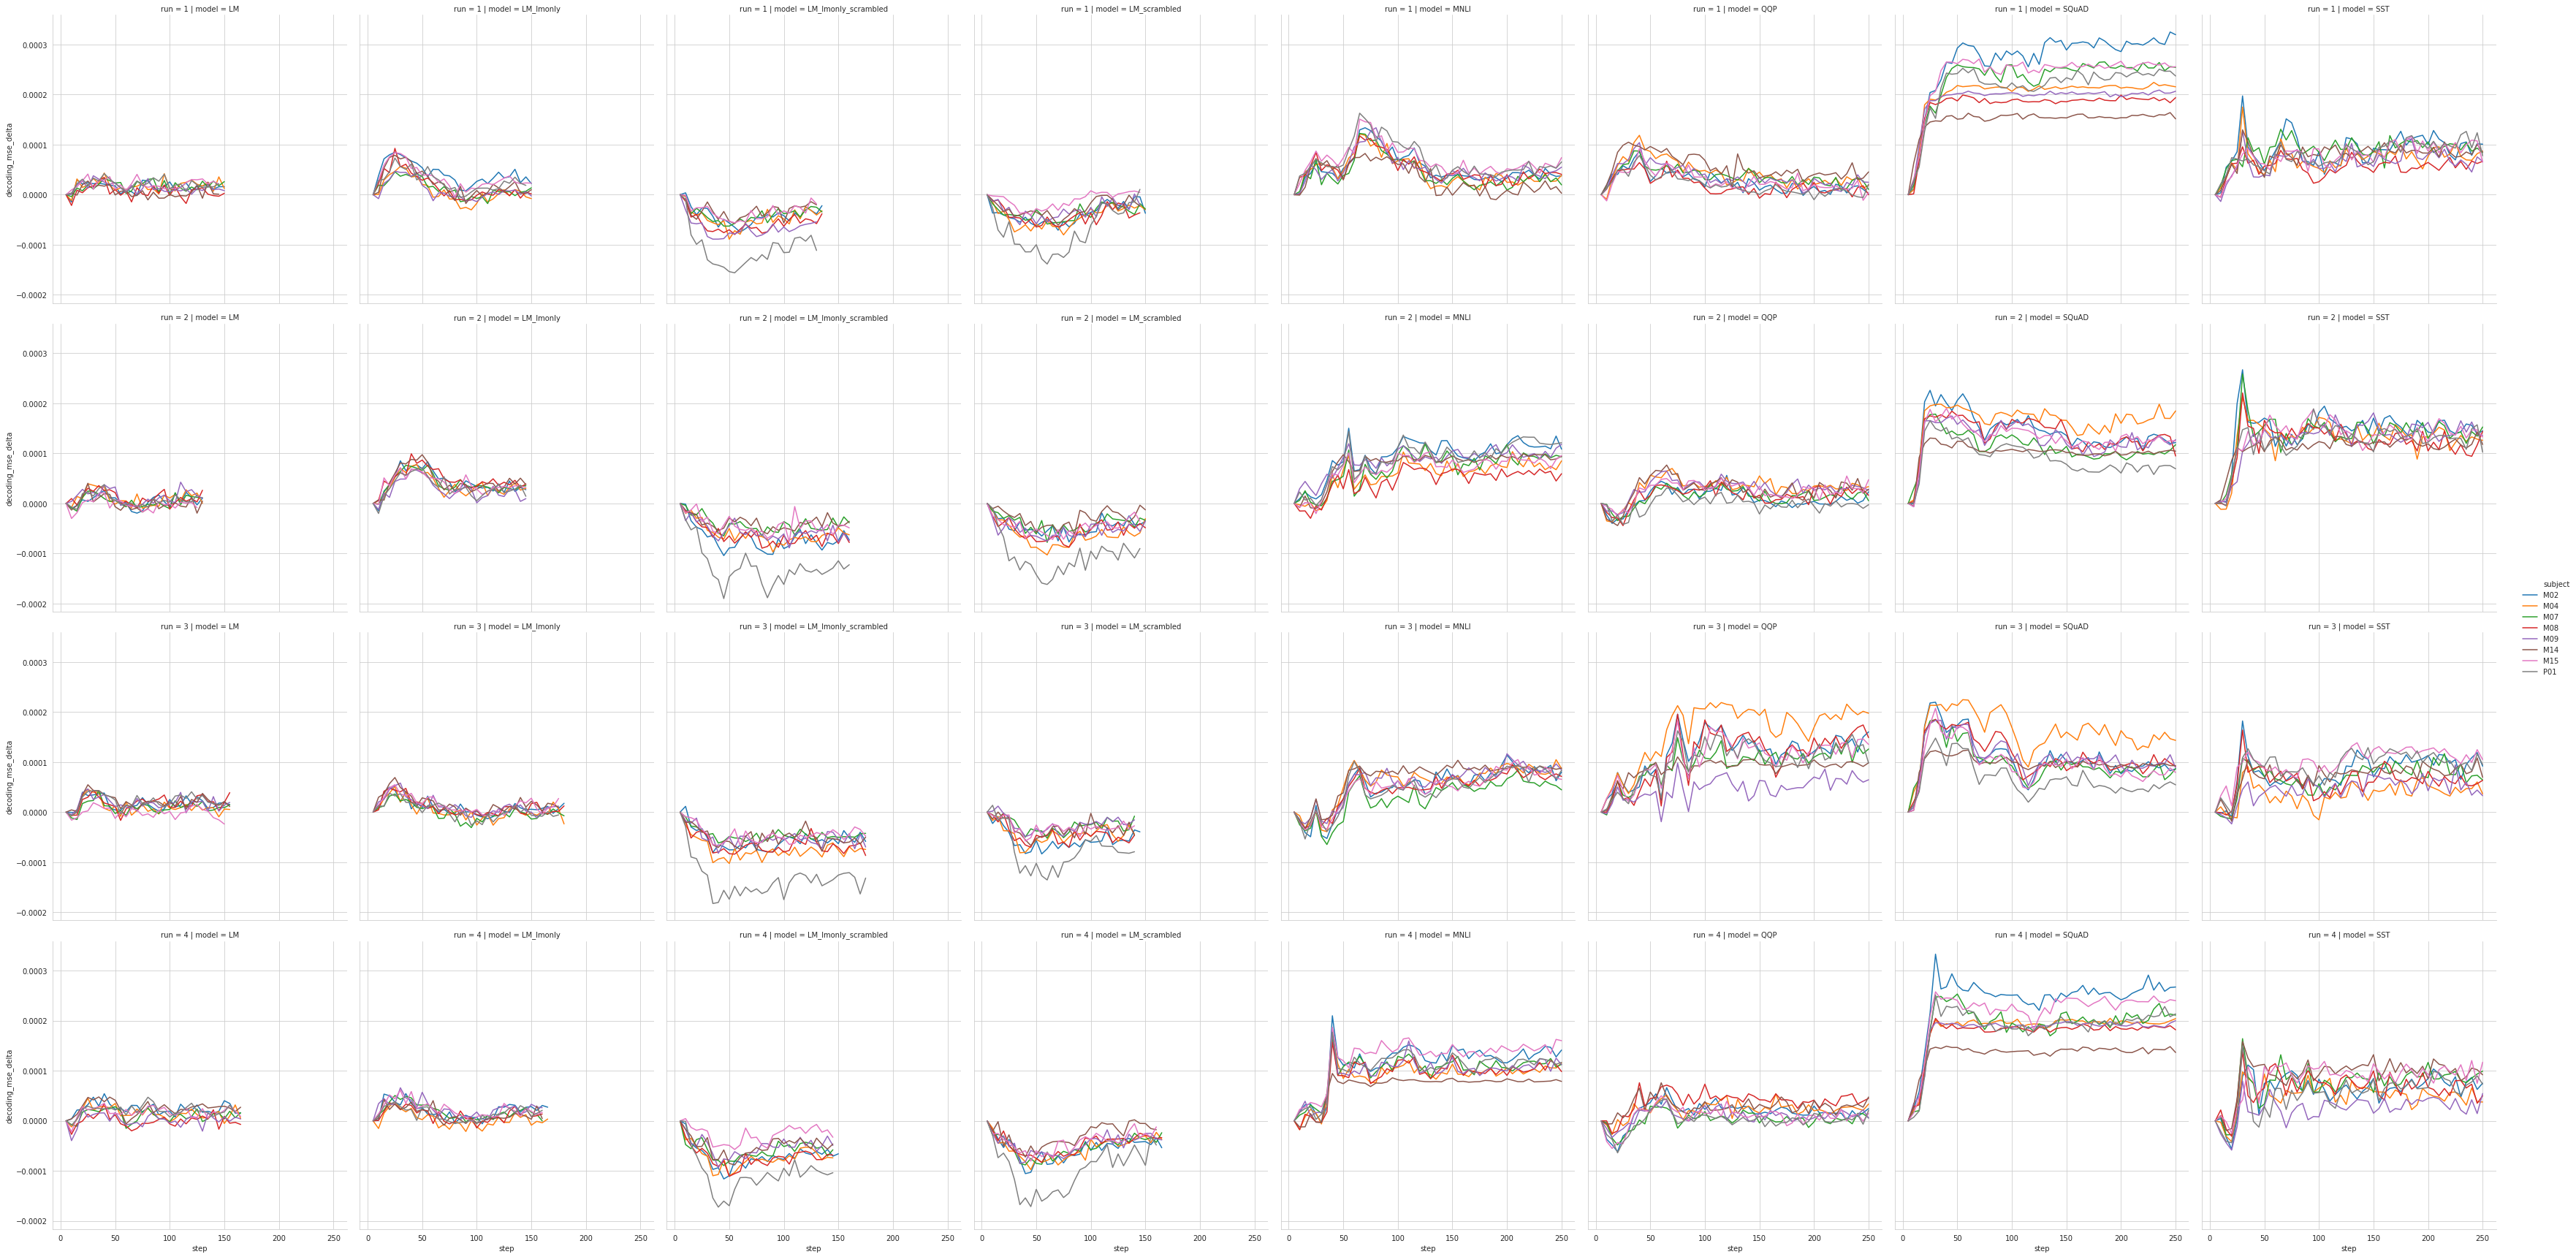

In [31]:
g = sns.FacetGrid(dfi, col="model", row="run", size=6)
g.map(sns.lineplot, "step", "decoding_mse_delta", "subject").add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


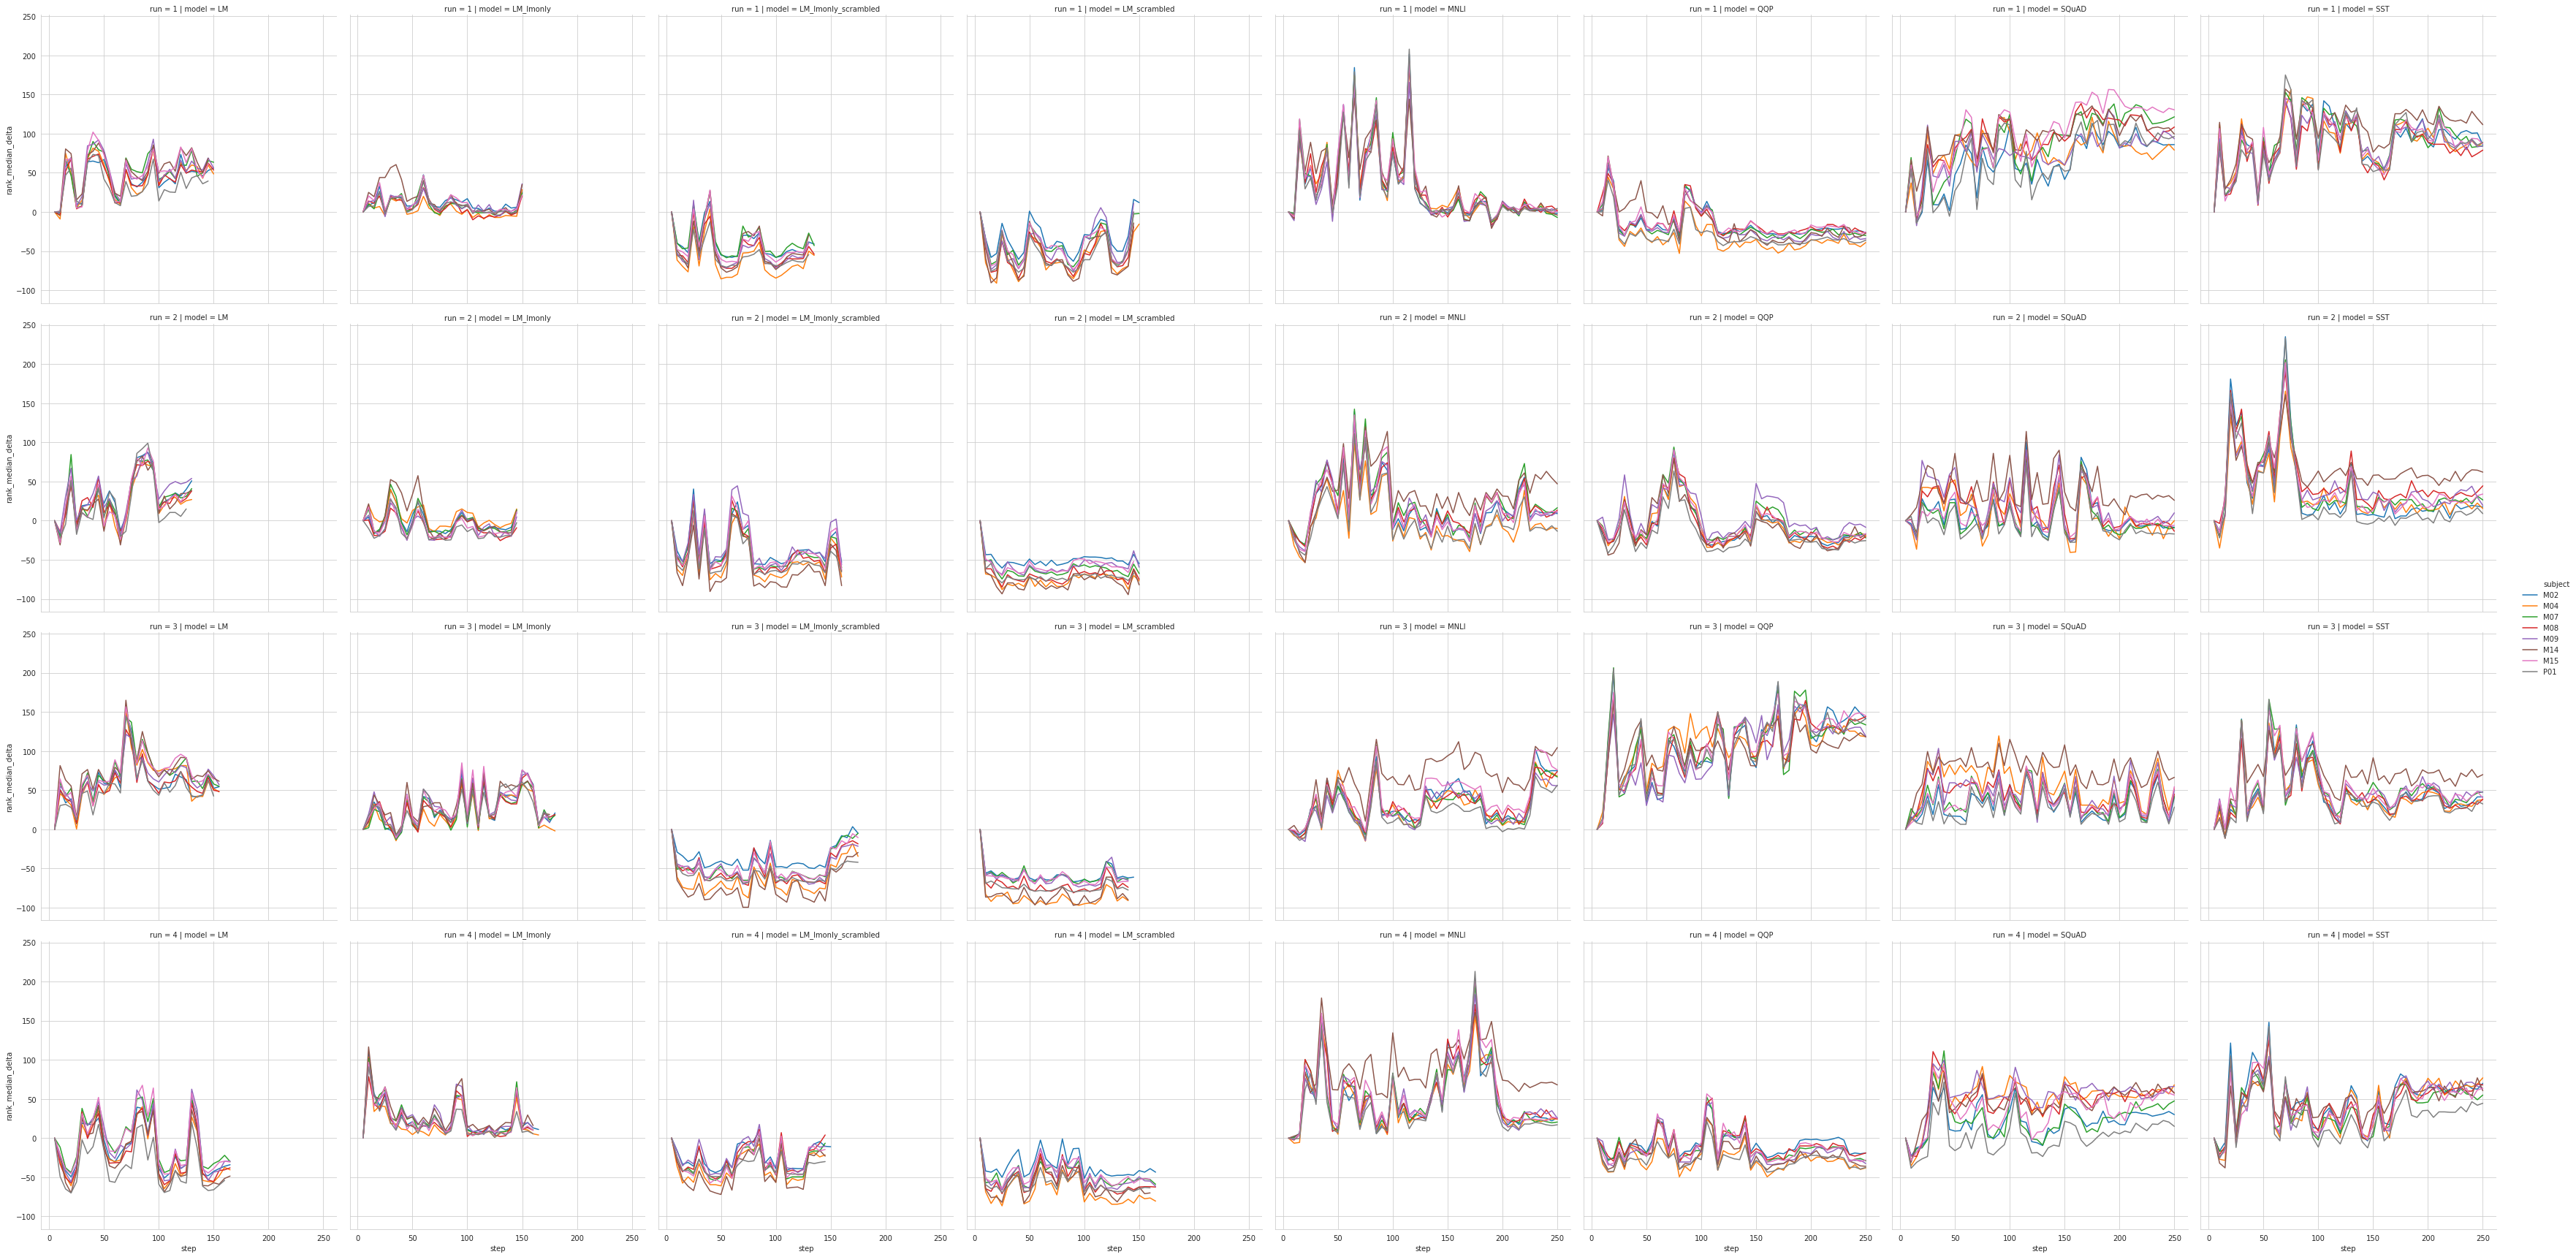

In [32]:
g = sns.FacetGrid(dfi, col="model", row="run", size=6)
g.map(sns.lineplot, "step", "rank_median_delta", "subject").add_legend()

### Gradient norm analysis

Text(0,0.5,'$\\Delta$(MSE)')

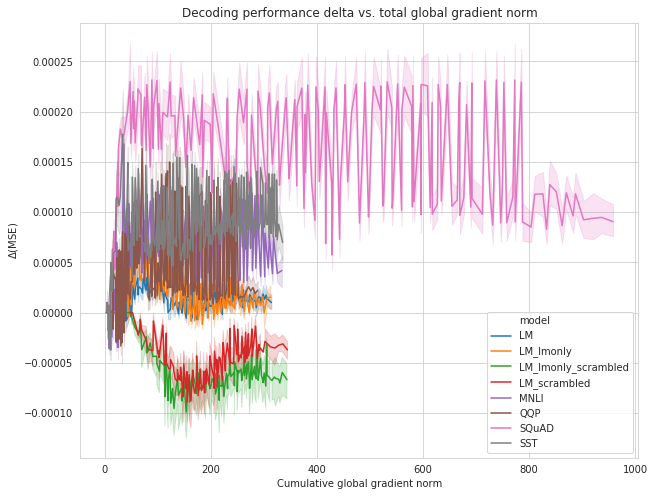

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=dfi, y="decoding_mse_delta", x="total_global_norms", hue="model", ax=ax)
ax.set_title("Decoding performance delta vs. total global gradient norm")
ax.set_xlabel("Cumulative global gradient norm")
ax.set_ylabel(MSE_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


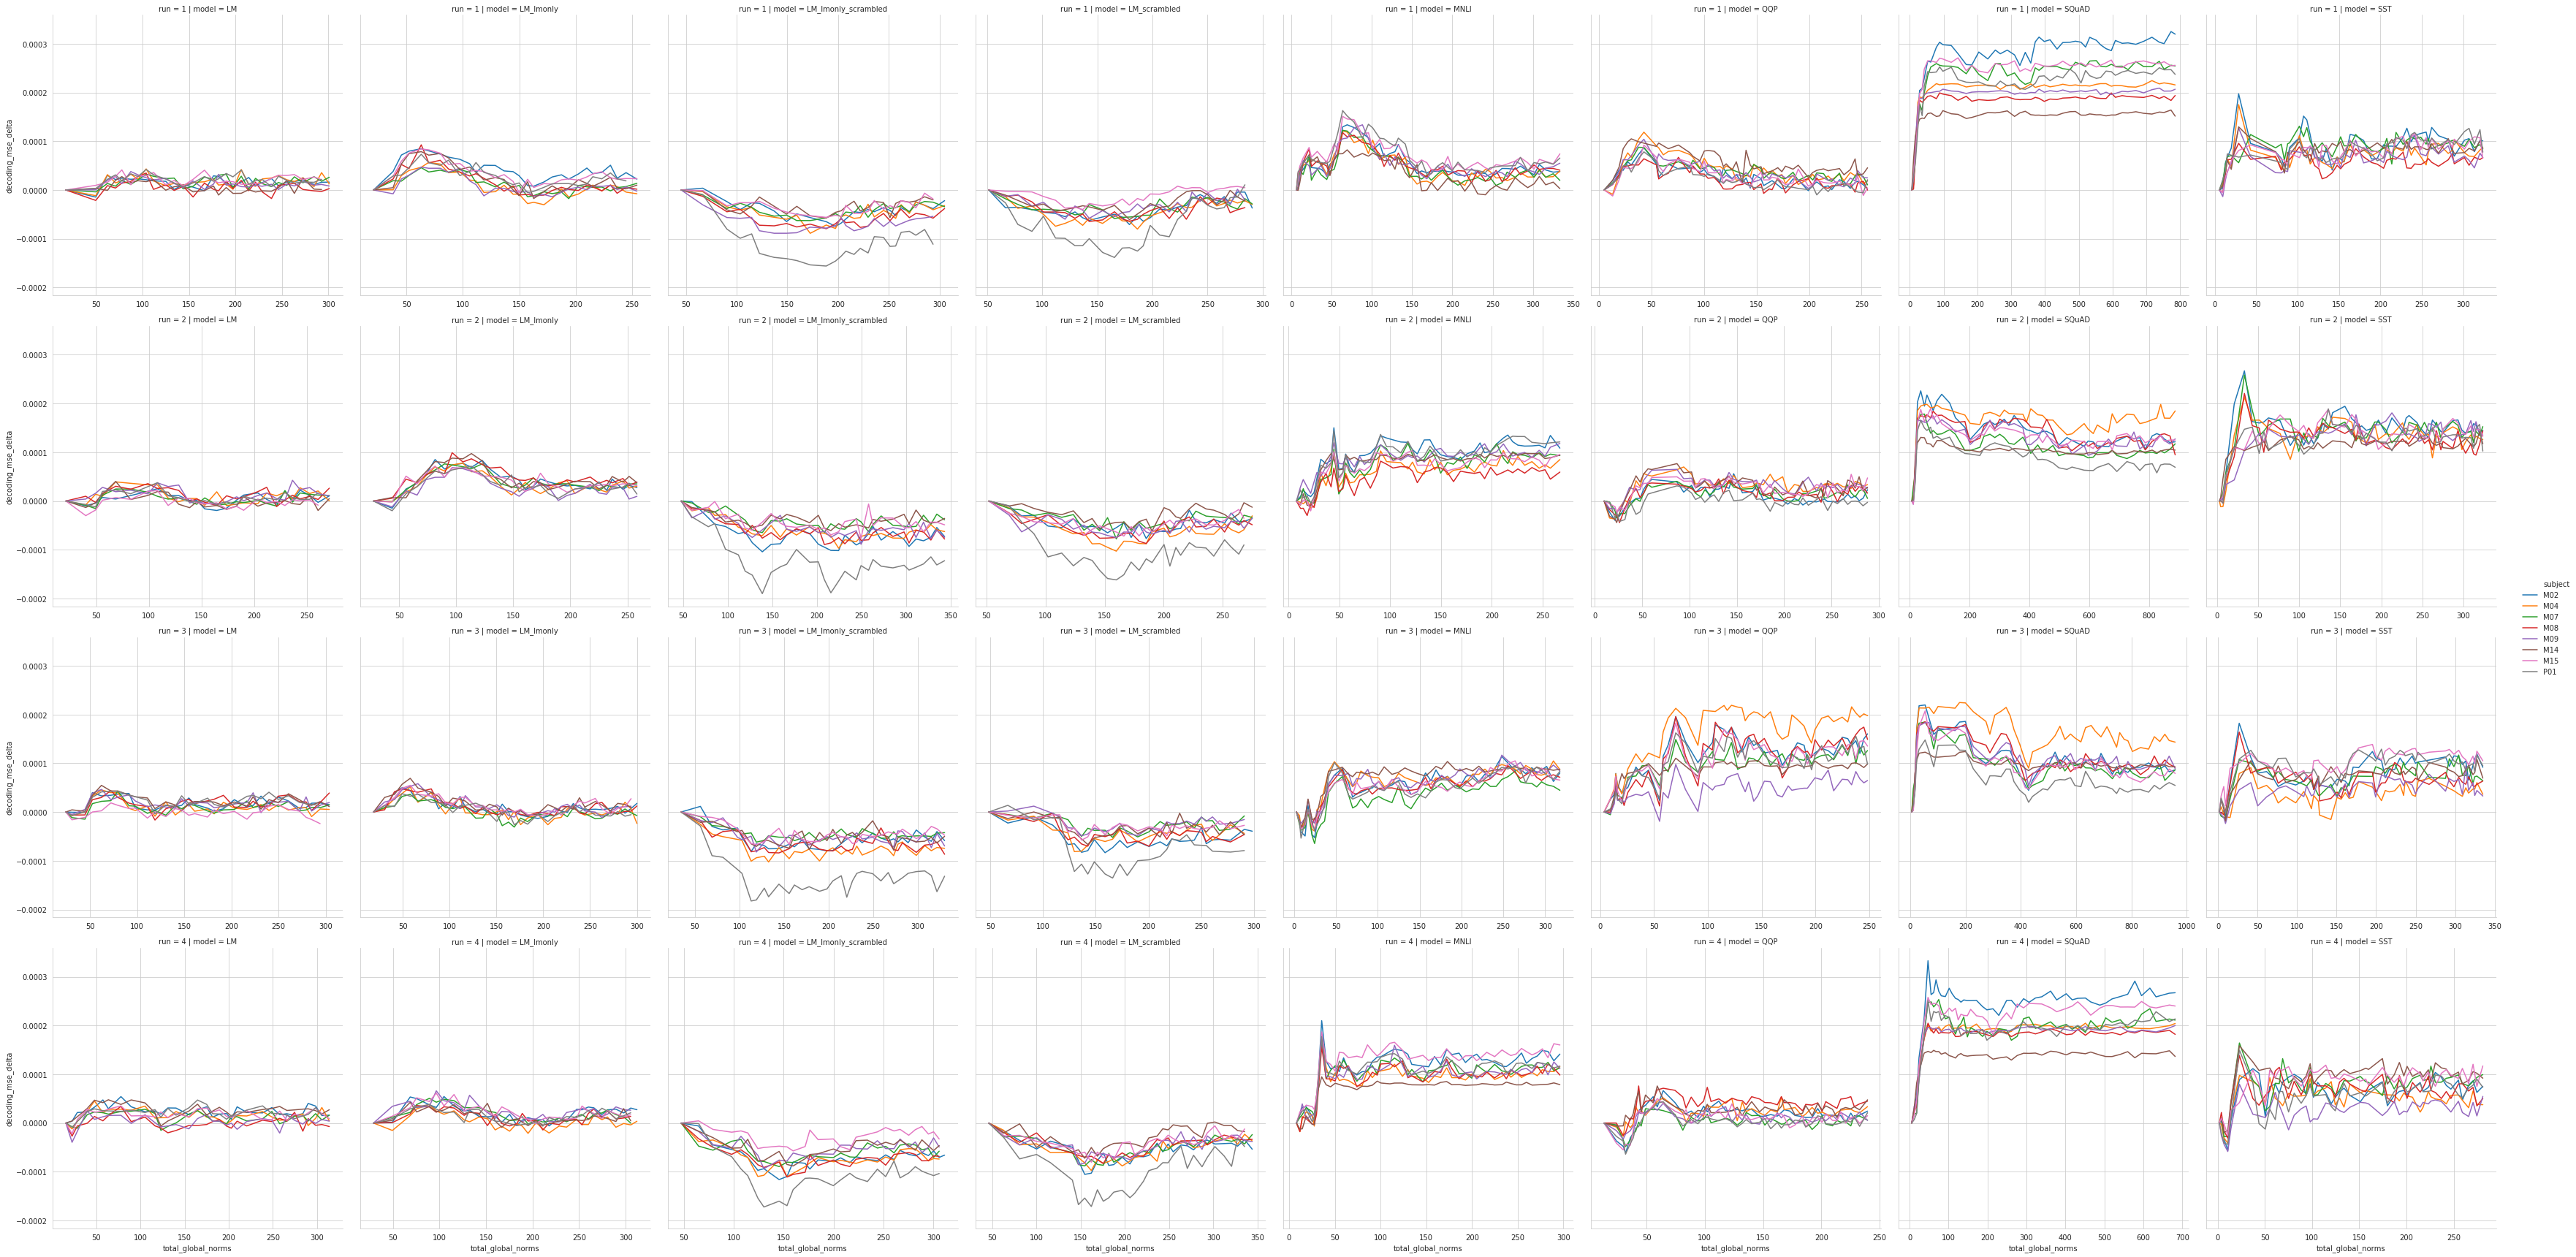

In [34]:
g = sns.FacetGrid(dfi, col="model", row="run", size=6, sharex=False, sharey=True)
g.map(sns.lineplot, "total_global_norms", "decoding_mse_delta", "subject").add_legend()

### Eval accuracy analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


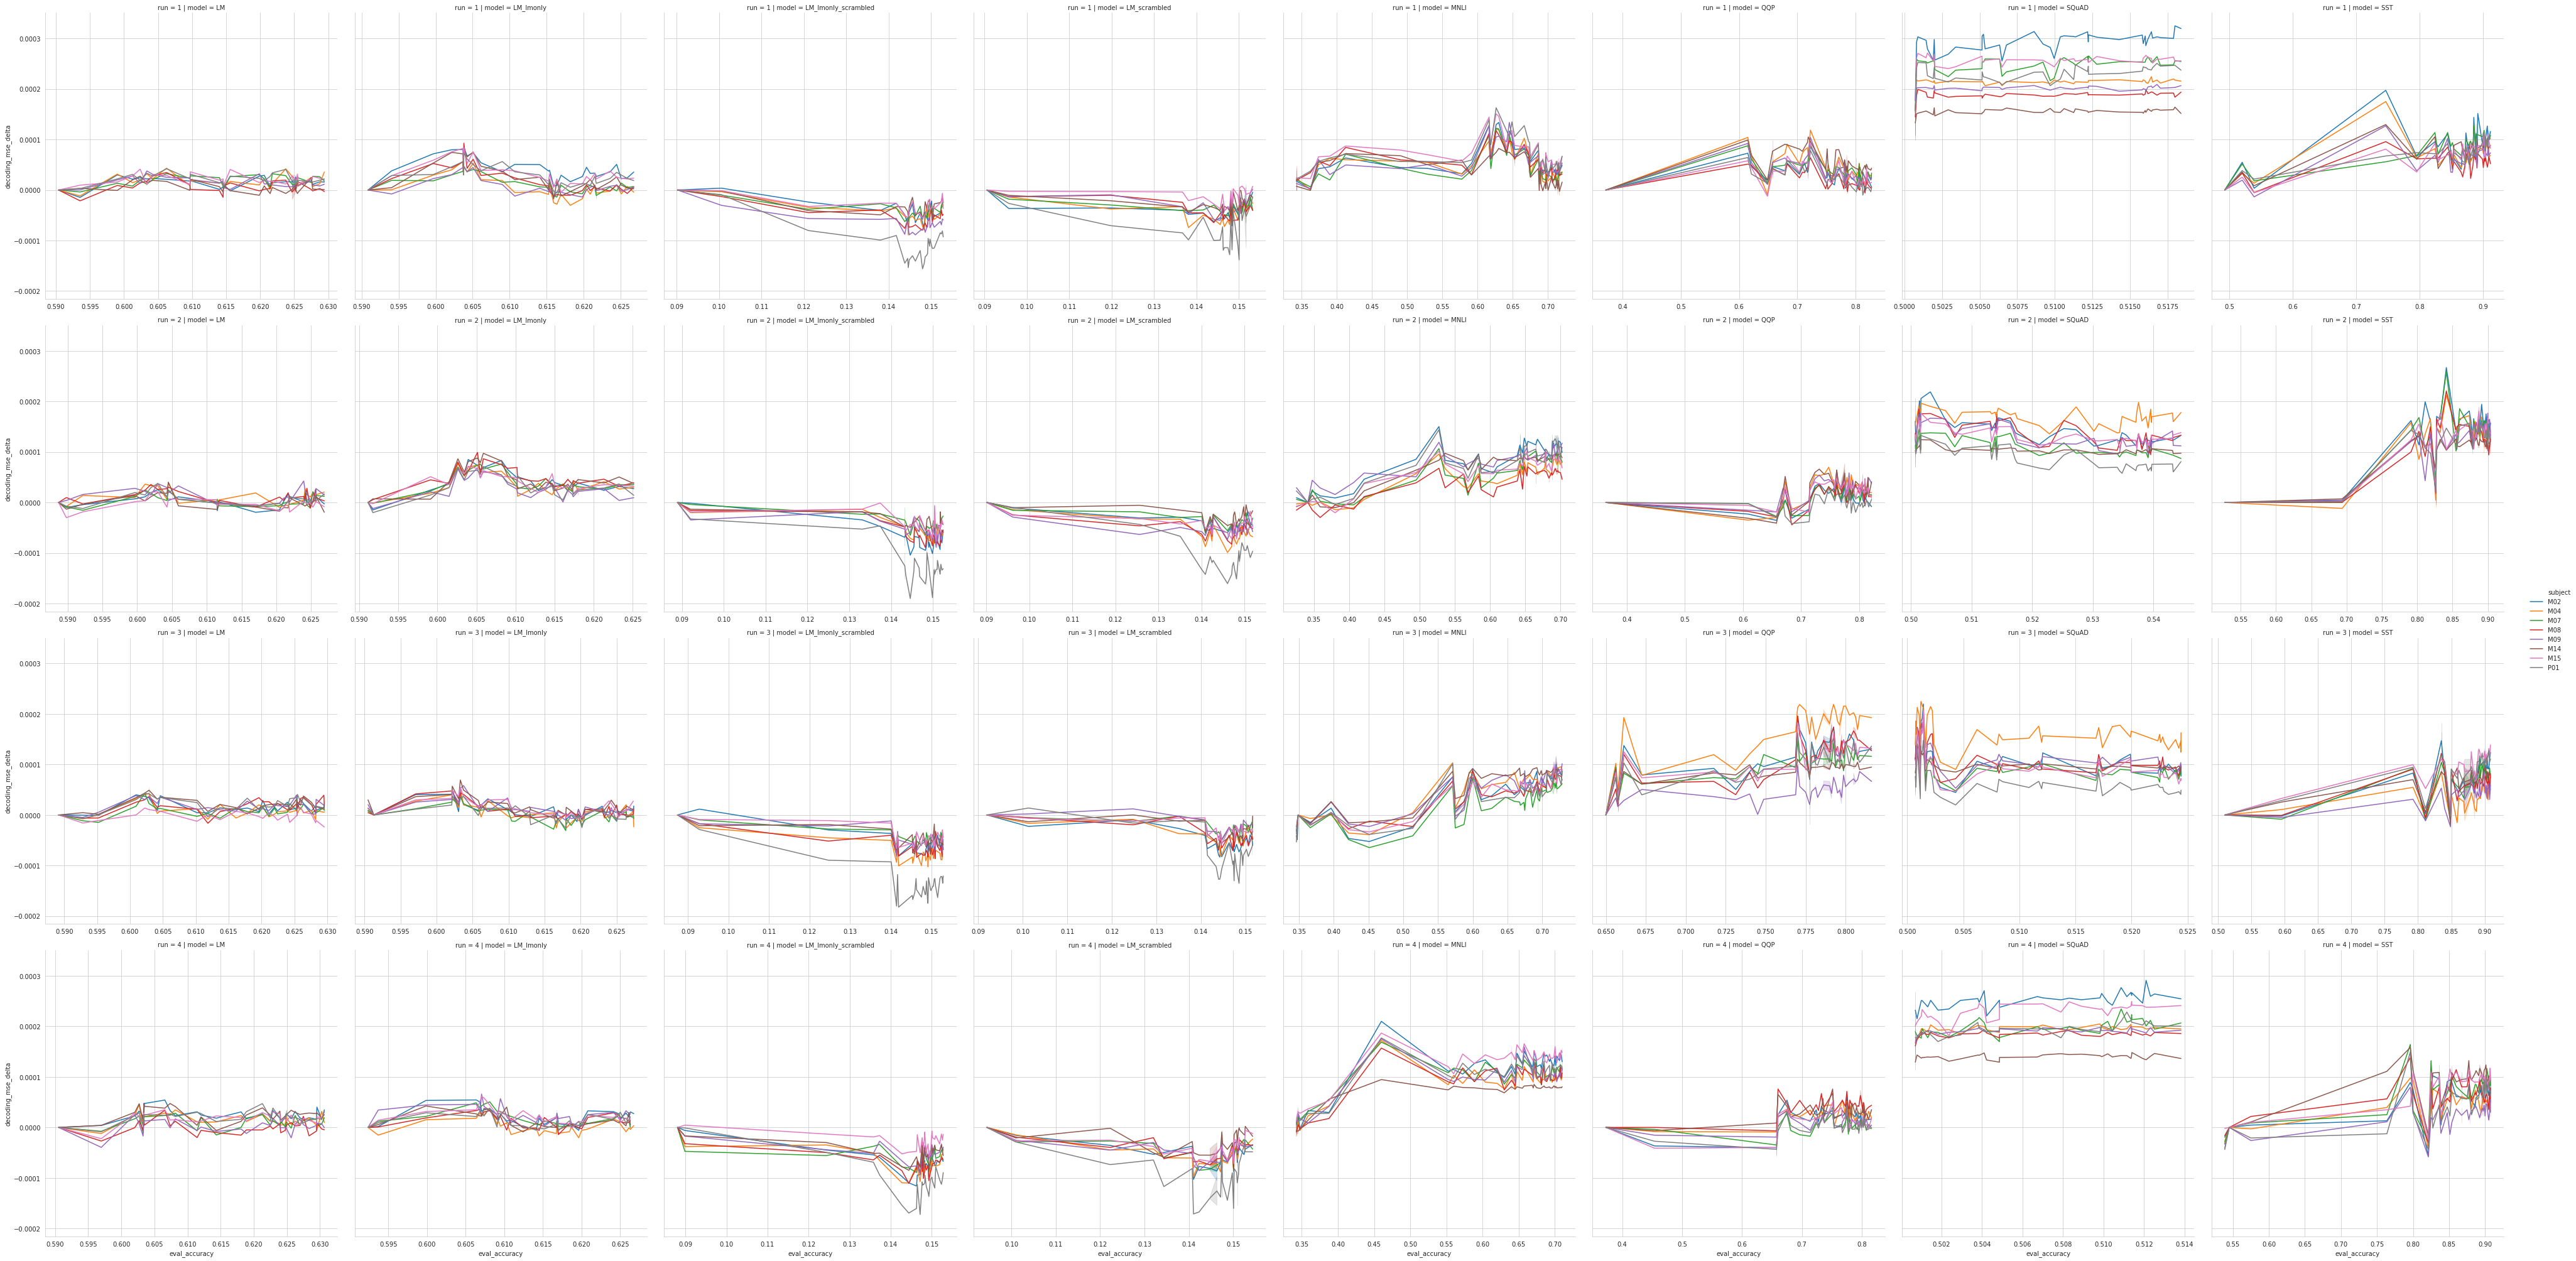

In [35]:
g = sns.FacetGrid(dfi, col="model", row="run", sharex=False, sharey=True, size=7)
g.map(sns.lineplot, "eval_accuracy", "decoding_mse_delta", "subject").add_legend()

## Per-subject analysis

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


Text(0.5,1,'subject average decoding mse delta, averaging across runs')

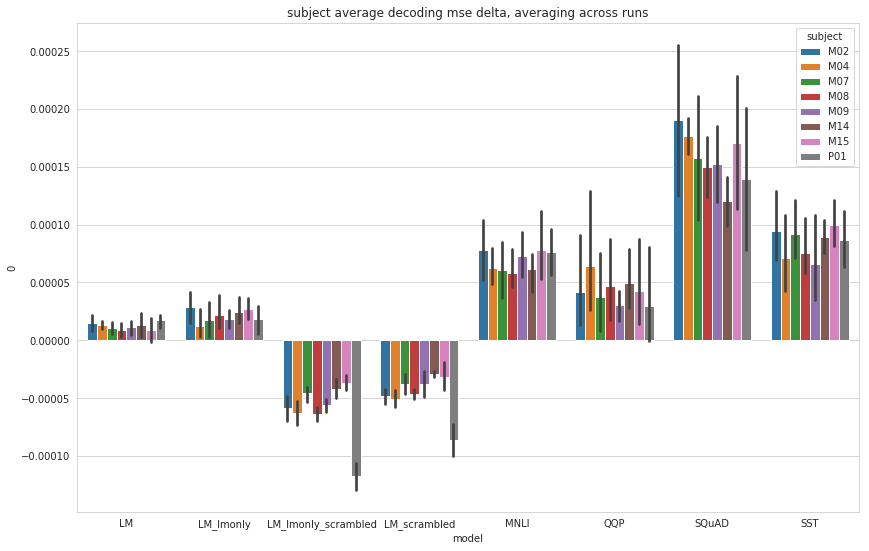

In [36]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject average decoding mse delta, averaging across runs")

Text(0.5,1,'subject max decoding mse delta, averaging across runs')

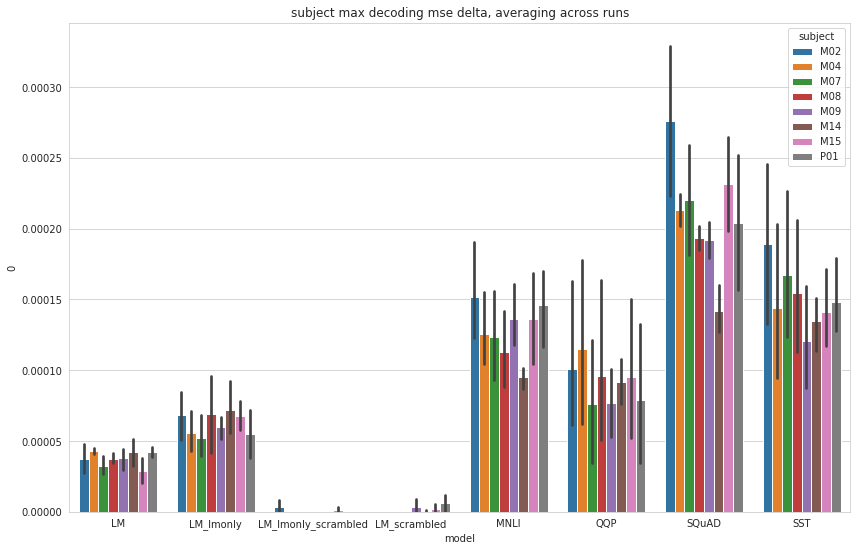

In [37]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject max decoding mse delta, averaging across runs")

Text(0.5,1,'subject average decoding mse delta, averaging across models and runs')

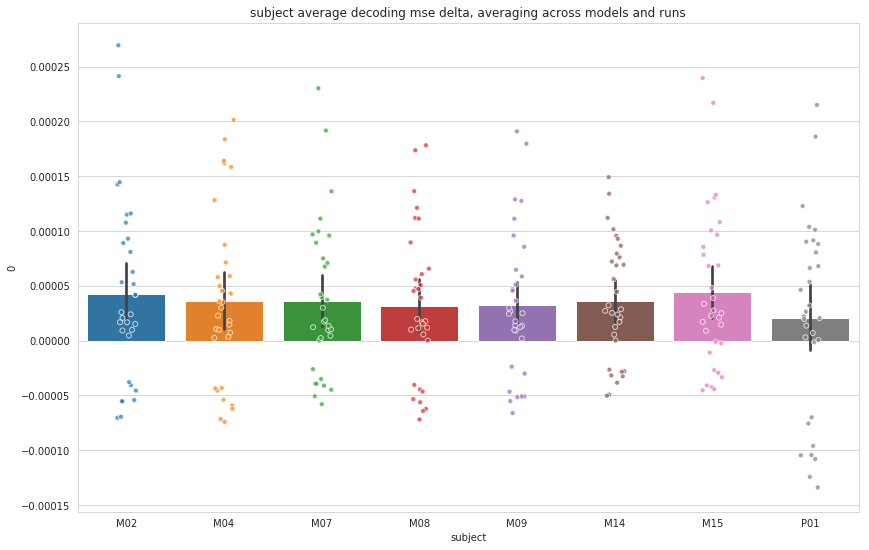

In [38]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="subject", y=0, ax=ax)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject average decoding mse delta, averaging across models and runs")

Text(0.5,1,'subject max decoding mse delta, averaging across models and runs')

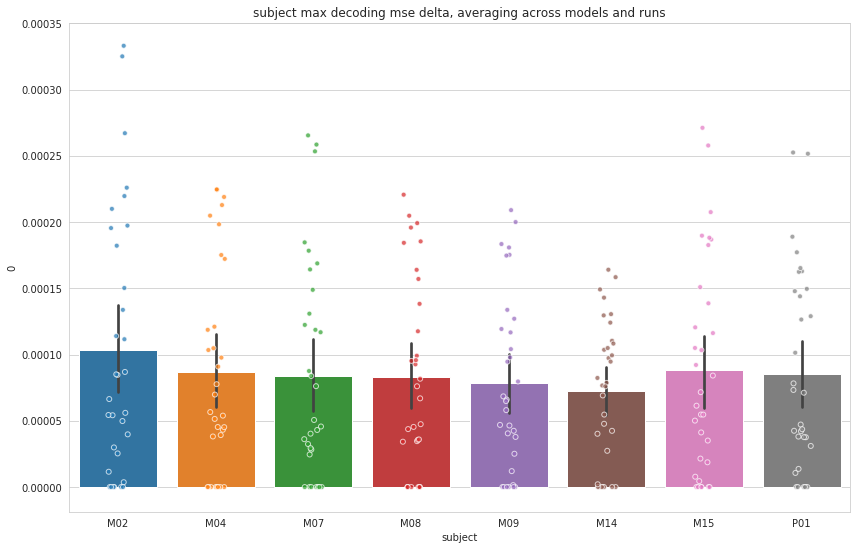

In [39]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).stack()).reset_index()
sns.barplot(data=dff, x="subject", y=0, ax=ax)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject max decoding mse delta, averaging across models and runs")

## Super high-level analyses

Within models, are there trends in different metrics across runs? (For example, is decoding performance tied to evaluation set accuracy?)

In [40]:
dfi.groupby(["model", "run"]).decoding_mse_delta.mean()

model                run
LM                   1      0.000015
                     2      0.000006
                     3      0.000014
                     4      0.000014
LM_lmonly            1      0.000021
                     2      0.000038
                     3      0.000009
                     4      0.000016
LM_lmonly_scrambled  1     -0.000053
                     2     -0.000062
                     3     -0.000065
                     4     -0.000063
LM_scrambled         1     -0.000037
                     2     -0.000054
                     3     -0.000041
                     4     -0.000052
MNLI                 1      0.000051
                     2      0.000073
                     3      0.000051
                     4      0.000098
QQP                  1      0.000033
                     2      0.000019
                     3      0.000104
                     4      0.000016
SQuAD                1      0.000209
                     2      0.000125
             

In [41]:
dfi.groupby(["model", "run"]).decoding_mse_delta.mean().groupby(["model"]).apply(lambda xs: xs.rank())

model                run
LM                   1      4.0
                     2      1.0
                     3      3.0
                     4      2.0
LM_lmonly            1      3.0
                     2      4.0
                     3      1.0
                     4      2.0
LM_lmonly_scrambled  1      4.0
                     2      3.0
                     3      1.0
                     4      2.0
LM_scrambled         1      4.0
                     2      1.0
                     3      3.0
                     4      2.0
MNLI                 1      2.0
                     2      3.0
                     3      1.0
                     4      4.0
QQP                  1      3.0
                     2      2.0
                     3      4.0
                     4      1.0
SQuAD                1      4.0
                     2      2.0
                     3      1.0
                     4      3.0
SST                  1      3.0
                     2      4.0
               

In [42]:
def rank_runs_by_col_agg(df, col, agg="mean"):
    return df.groupby(["model", "run"])[col].agg(agg).groupby(["model"]).apply(lambda model_runs: model_runs.rank())

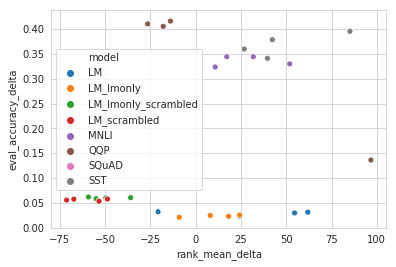

In [43]:
sns.scatterplot(data=dfi.groupby(["model", "run"])[["eval_accuracy_delta", "rank_mean_delta"]].median().reset_index(),
                x="rank_mean_delta", y="eval_accuracy_delta", hue="model")

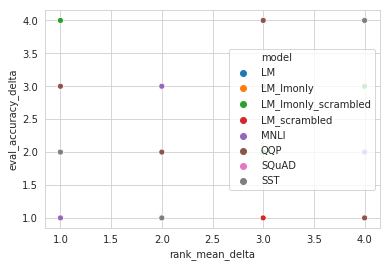

In [44]:
sns.scatterplot(data=pd.concat([rank_runs_by_col_agg(dfi, "decoding_mse_delta", "median"),
                                rank_runs_by_col_agg(dfi, "eval_accuracy_delta", "median"),
                                rank_runs_by_col_agg(dfi, "rank_mean_delta", "median")],
                               axis=1).reset_index(),
                x="rank_mean_delta", y="eval_accuracy_delta", hue="model")

## Statistical analyses

### Fine-tuning and brain decoding

Statistical claim: fine-tuning on task X *does not improve* brain decoding performance. (LM representations are at the upper bound on brain decoding performance.)

We'll evaluate this by paired sample t-test, comparing per-subject brain decoding performance at the *start* of fine-tuning and at the *end* of fine-tuning.

In [45]:
metric = "decoding_mse_delta"
start_perfs = df.query("step == %i" % checkpoint_steps[0]) \
    .reset_index(level="step", drop=True).sort_index()
end_perfs = df.query("step == %i" % checkpoint_steps[-1]) \
    .reset_index(level="step", drop=True).sort_index()

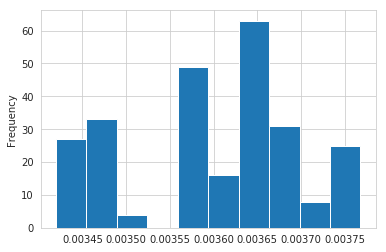

In [46]:
start_perfs.mse.plot.hist()

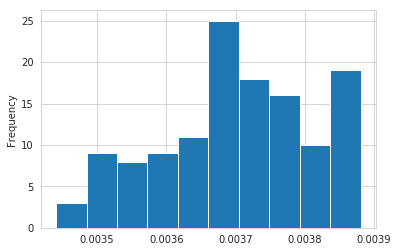

In [47]:
end_perfs.mse.plot.hist()

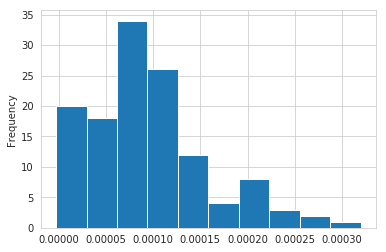

In [48]:
(end_perfs.mse - start_perfs.mse).plot.hist()

In [49]:
import scipy.stats as st
st.ttest_rel(start_perfs.mse, end_perfs.mse)

ValueError: unequal length arrays

In [ ]:
(end_perfs.rank_median - start_perfs.rank_median).plot.hist()

In [ ]:
st.ttest_rel(start_perfs.rank_median, end_perfs.rank_median)

-------------

In [ ]:
sns.scatterplot(data=dfi, x="mse", y="rank_median", hue="model")
plt.xlim((3e-3, 4e-3))

In [ ]:
st.pearsonr(dfi.mse, dfi.rank_median)

In [ ]:
st.pearsonr(dfi.decoding_mse_delta, dfi.rank_median_delta)